# Linear Regression

### Install the required libraries
```bash
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow
```

In [ ]:
# !pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

### Load and split the data

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from sklearn.model_selection import train_test_split

# Constants for the linear equation
a = 2  # Slope
c = 3  # Intercept

# Generate dataset with some noise and the model function is -z = ax + c
np.random.seed(42)  # For reproducibility
x_data = np.linspace(-10, 10, 100)  # Generate 100 data points
z_data = a * x_data + c + np.random.normal(0, 1, 100)  # Add some noise

# Split dataset into training and validation
x_train, x_val, z_train, z_val = train_test_split(x_data, z_data, test_size=0.2, random_state=42)
x_test, x_val, z_test, z_val = train_test_split(x_val, z_val, test_size=0.5, random_state=42)


### Build the model

In [3]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1])
])

model.compile(optimizer='sgd', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(x_train, z_train, validation_data=(x_val, z_val), epochs=100, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 31ms/step - loss: 148.9045 - val_loss: 6.8018
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 7.8797 - val_loss: 6.0805
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 7.0335 - val_loss: 5.4534
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 6.3608 - val_loss: 5.0536
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 5.8199 - val_loss: 4.1015
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - l

### Validate the model

1/1 [==============================] - 0s 19ms/step
[[ -3.9068348]
 [ 11.328476 ]
 [-17.495085 ]
 [ -4.7303658]
 [  0.6225817]
 [ 12.563771 ]
 [ 15.446128 ]
 [-10.083313 ]
 [ 19.56378  ]
 [ -8.436252 ]]
[ -4.7243776   11.64422389 -16.50328585  -2.62246929  -0.70074421
  14.05959315  15.10356044 -10.6352968   19.46071391  -8.04358291]
Loss: 279.3726451711599
R2: -19.08543022439749


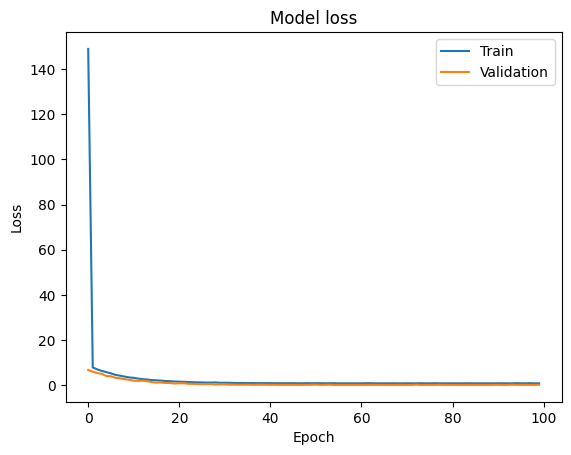

In [5]:
# validate and test the model
z_pred = model.predict(x_test)
print(z_pred)
print(z_test)
print('Loss:', np.mean((z_pred - z_test)**2))

# R2 score
mean_z = np.mean(z_test)
ss_tot = np.sum((z_test - mean_z)**2)
ss_res = np.sum((z_test - z_pred)**2)
r2 = 1 - ss_res/ss_tot
print('R2:', r2)

# Plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Save Frozen Model

In [6]:
# Convert to a TensorFlow function and get the concrete function
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]

print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to protobuf
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="linear_model_frozen.pb",
                  as_text=False)

Frozen model layers: 
x
sequential/dense/MatMul/ReadVariableOp/resource
sequential/dense/BiasAdd/ReadVariableOp/resource
sequential/dense/MatMul/ReadVariableOp
sequential/dense/MatMul
sequential/dense/BiasAdd/ReadVariableOp
sequential/dense/BiasAdd
NoOp
Identity
Frozen model inputs: 
[<tf.Tensor 'x:0' shape=(None, 1) dtype=float32>]
Frozen model outputs: 
[<tf.Tensor 'Identity:0' shape=(None, 1) dtype=float32>]


2024-02-10 17:50:40.562310: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-02-10 17:50:40.562658: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


'./frozen_models/linear_model_frozen.pb'